<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/cnn/od_cats_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

Based on https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

## Imports and Setup

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
# if this fails, do a factory reset of runtime
assert tf.__version__ == '2.7.0'

In [4]:
!nvidia-smi

Sun Nov 28 11:43:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3135, done.
remote: Counting objects: 100% (3135/3135), done.
remote: Compressing objects: 100% (2649/2649), done.
remote: Total 3135 (delta 809), reused 1344 (delta 442), pack-reused 0
Receiving objects: 100% (3135/3135), 33.35 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (809/809), done.


In [6]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 13.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [7]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of requests to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pyyaml to determine which version is compatible with other r

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [8]:
!mkdir train
!mkdir test

In [9]:
%%bash
cd train
wget https://images.ctfassets.net/82d3r48zq721/45liwTLsDMSJt4N22RqrHX/cd992f88ca8737f95b085212906d6d86/Can-cats-and-dogs-get-coronavirus_resized.jpg
wget https://cats-dogs-shop.de/imgsrv/deDE/7735/1/3049484289682/SLIDER-STARTSEITE/Slider-Hund-Katze.jpg
wget https://ichef.bbci.co.uk/news/976/cpsprodpb/140B3/production/_111699028_gettyimages-1168451046.jpg

--2021-11-28 11:45:08--  https://images.ctfassets.net/82d3r48zq721/45liwTLsDMSJt4N22RqrHX/cd992f88ca8737f95b085212906d6d86/Can-cats-and-dogs-get-coronavirus_resized.jpg
Resolving images.ctfassets.net (images.ctfassets.net)... 65.9.82.51, 65.9.82.13, 65.9.82.57, ...
Connecting to images.ctfassets.net (images.ctfassets.net)|65.9.82.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93553 (91K) [image/jpeg]
Saving to: ‘Can-cats-and-dogs-get-coronavirus_resized.jpg’

     0K .......... .......... .......... .......... .......... 54% 11.3M 0s
    50K .......... .......... .......... .......... .         100% 58.0M=0.005s

2021-11-28 11:45:08 (17.8 MB/s) - ‘Can-cats-and-dogs-get-coronavirus_resized.jpg’ saved [93553/93553]

--2021-11-28 11:45:08--  https://cats-dogs-shop.de/imgsrv/deDE/7735/1/3049484289682/SLIDER-STARTSEITE/Slider-Hund-Katze.jpg
Resolving cats-dogs-shop.de (cats-dogs-shop.de)... 138.201.228.103, 188.40.17.0, 188.40.16.255, ...
Connecting to cats-dog

In [10]:
%%bash
cd test
wget https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg

--2021-11-28 11:45:09--  https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72452 (71K) [image/jpeg]
Saving to: ‘dog-and-cat-cover.jpg’

     0K .......... .......... .......... .......... .......... 70% 74.7M 0s
    50K .......... ..........                                 100% 75.9M=0.001s

2021-11-28 11:45:09 (75.0 MB/s) - ‘dog-and-cat-cover.jpg’ saved [72452/72452]



In [11]:
!ls -l train

total 252
-rw-r--r-- 1 root root  45550 Apr 10  2020 _111699028_gettyimages-1168451046.jpg
-rw-r--r-- 1 root root  93553 Feb 13  2021 Can-cats-and-dogs-get-coronavirus_resized.jpg
-rw-r--r-- 1 root root 111831 Nov 28 11:45 Slider-Hund-Katze.jpg


In [12]:
!ls -l test

total 72
-rw-r--r-- 1 root root 72452 Jan 22  2018 dog-and-cat-cover.jpg


In [13]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [14]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    min_score_thresh=0.3):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Data

In [15]:
import os
from skimage import data, io, filters

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "train")
type = ".jpg"

images = []
file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
for f in file_names:
    images.append(io.imread(f))

train_images_np = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


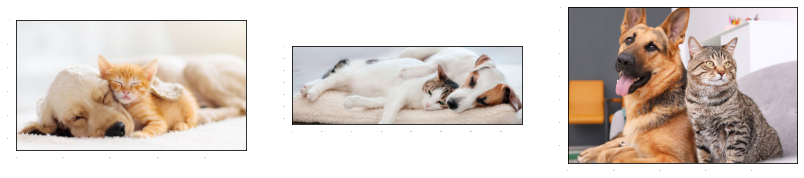

In [16]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Inference using existing model

In [17]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2021-11-28 11:45:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.69.128, 2a00:1450:4013:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.69.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   307MB/s    in 0.8s    

2021-11-28 11:45:12 (307 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [18]:
!ls -l ssd_resnet50_v1_fpn_640x640_coco17_tpu-8

total 16
drwxr-x--- 2 345018 89939 4096 Jul 10  2020 checkpoint
-rw-r----- 1 345018 89939 4407 Jul 11  2020 pipeline.config
drwxr-x--- 4 345018 89939 4096 Jul 10  2020 saved_model


In [19]:
pipeline_config = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config'
model_dir = 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [20]:
label_map_path = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
# label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index_complete = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
category_index_complete

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [21]:
idx = 2
image_np = train_images_np[idx].copy()

In [22]:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

In [23]:
dt_boxes = detections['detection_boxes'][0].numpy()
dt_classes = detections['detection_classes'][0].numpy().astype(int) + 1
dt_scores = detections['detection_scores'][0].numpy()

dt_boxes.shape, dt_classes.shape, dt_scores.shape

((100, 4), (100,), (100,))

In [24]:
dt_classes[:5]

array([18, 17, 62, 18, 17])

In [25]:
dt_scores[:5]

array([0.675109  , 0.6717007 , 0.35543263, 0.30652547, 0.30373895],
      dtype=float32)

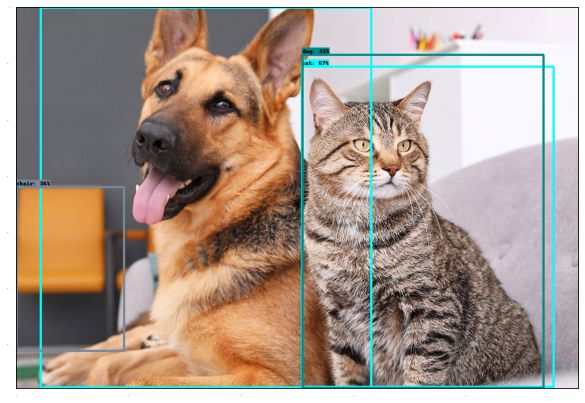

In [26]:
  plot_detections(
      image_np,
      dt_boxes,
      dt_classes,
      dt_scores,
      category_index_complete,
      min_score_thresh=0.3)


# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [27]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 2

category_index = {
    1: {'id': 1, 'name': 'dog'},
    2: {'id': 2, 'name': 'cat'}
    }

In [28]:
# one bounding box per animal, first dog than cat
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [29]:
gt_boxes = [
            np.array([[0.31940104, 0.07889344, 0.92606771, 0.48155738],
                       [0.22606771, 0.32991803, 0.85273438, 0.80737705]], dtype=np.float32),
            np.array([[0.01606771, 0.68072917, 0.87440104, 0.93541667],
                      [0.10773437, 0.03072917, 0.92773438, 0.725     ]], dtype=np.float32),
            np.array([[0.        , 0.175     , 1.        , 0.548     ],
                      [0.15940104, 0.509     , 1.        , 0.939     ]], dtype=np.float32)
]

In [30]:
gt_boxes = np.array(gt_boxes)
gt_boxes

array([[[0.31940103, 0.07889344, 0.9260677 , 0.48155737],
        [0.2260677 , 0.32991803, 0.8527344 , 0.80737704]],

       [[0.01606771, 0.68072915, 0.87440103, 0.9354167 ],
        [0.10773437, 0.03072917, 0.9277344 , 0.725     ]],

       [[0.        , 0.175     , 1.        , 0.548     ],
        [0.15940104, 0.509     , 1.        , 0.939     ]]], dtype=float32)

In [31]:
gt_classes = np.ones_like(gt_boxes[:, :, 0], dtype='int')
gt_classes

array([[1, 1],
       [1, 1],
       [1, 1]])

In [32]:
gt_classes[:, 1] = 2
gt_classes

array([[1, 2],
       [1, 2],
       [1, 2]])

# Let's just visualize training data as a sanity check


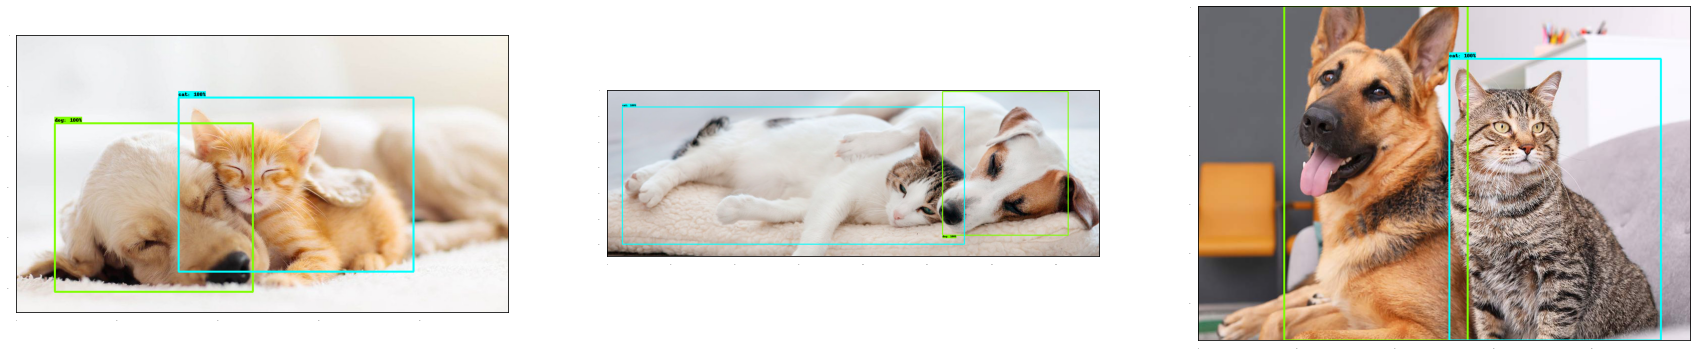

In [33]:
plt.figure(figsize=(30, 15))
for idx in range(train_images_np.shape[0]):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      gt_classes[idx],
      np.ones_like(gt_classes[idx], dtype=np.float32), # give boxes a score of 100%
      category_index)
plt.show()

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [34]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, gt_class_np) in zip(
    train_images_np, gt_boxes, gt_classes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(gt_class_np - label_id_offset, dtype=tf.int32)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [35]:
tf.keras.backend.clear_session()

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.train.Checkpoint(model=fake_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


# Eager mode custom training loop



In [36]:
%%time

tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 500

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
Cause: Unable to locate the source code of <function get_model_train_step_function.<locals>.train_step_fn at 0x7ff2784fb3b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function get_model_train_step_function.<locals>.train_step_fn at 0x7ff2784fb3b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_conv

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  learning phase methods until those APIs are fully removed from the public API.


batch 0 of 500, loss=1.4083143
batch 10 of 500, loss=0.24203232
batch 20 of 500, loss=0.08664544
batch 30 of 500, loss=0.038836032
batch 40 of 500, loss=0.021044482
batch 50 of 500, loss=0.0140470695
batch 60 of 500, loss=0.010802452
batch 70 of 500, loss=0.009122131
batch 80 of 500, loss=0.008119095
batch 90 of 500, loss=0.007410837
batch 100 of 500, loss=0.0068580355
batch 110 of 500, loss=0.00639948
batch 120 of 500, loss=0.0060080467
batch 130 of 500, loss=0.005666876
batch 140 of 500, loss=0.005365346
batch 150 of 500, loss=0.005096187
batch 160 of 500, loss=0.004853977
batch 170 of 500, loss=0.0046346015
batch 180 of 500, loss=0.0044347974
batch 190 of 500, loss=0.004251947
batch 200 of 500, loss=0.0040838905
batch 210 of 500, loss=0.0039288457
batch 220 of 500, loss=0.0037853126
batch 230 of 500, loss=0.0036520213
batch 240 of 500, loss=0.0035278895
batch 250 of 500, loss=0.0034119878
batch 260 of 500, loss=0.003303506
batch 270 of 500, loss=0.0032017427
batch 280 of 500, loss=0

# Inference with new model!

In [37]:
@tf.function
def fined_tuned_detect_fn(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


## Train

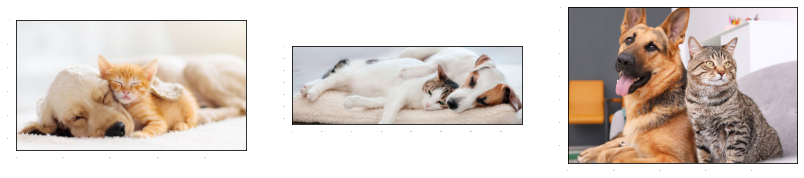

In [38]:
plt.rcParams['figure.figsize'] = [14, 7]

for idx, image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(image_np)
plt.show()

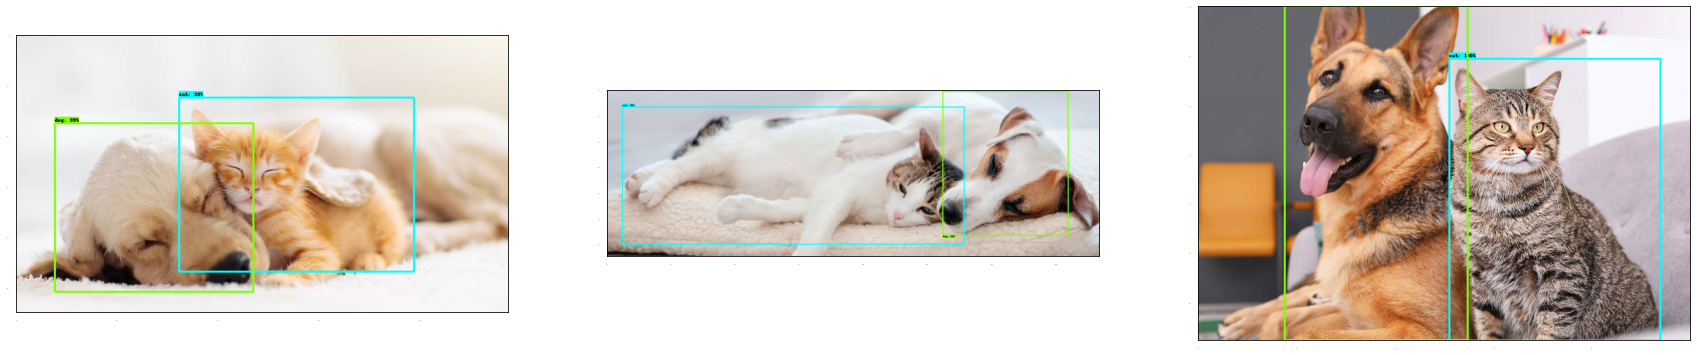

In [43]:
plt.figure(figsize=(30, 15))
for idx in range(train_images_np.shape[0]):
  plt.subplot(2, 3, idx+1)
  image_np = train_images_np[idx].copy()

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections = fined_tuned_detect_fn(input_tensor)
  dt_boxes = detections['detection_boxes'][0].numpy()
  dt_classes = detections['detection_classes'][0].numpy().astype(int) + 1
  dt_scores = detections['detection_scores'][0].numpy()
  plot_detections(
      image_np,
      dt_boxes,
      dt_classes,
      dt_scores,
      category_index,
      min_score_thresh=0.50)
plt.show()

In [40]:
import os
from skimage import data, io, filters

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "test")
type = ".jpg"

images = []
file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
for f in file_names:
    images.append(io.imread(f))

test_images_np = np.array(images)

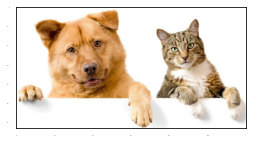

In [41]:
plt.rcParams['figure.figsize'] = [14, 7]

for idx, image_np in enumerate(test_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(image_np)
plt.show()

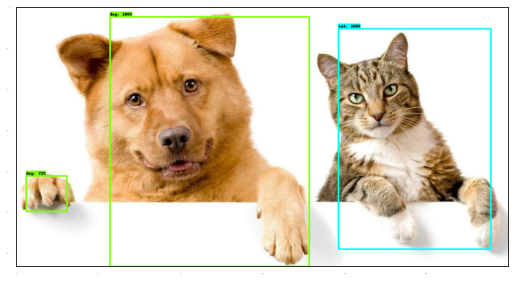

In [44]:
plt.figure(figsize=(30, 15))
for idx in range(test_images_np.shape[0]):
  plt.subplot(2, 3, idx+1)
  image_np = test_images_np[idx].copy()

  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections = fined_tuned_detect_fn(input_tensor)
  dt_boxes = detections['detection_boxes'][0].numpy()
  dt_classes = detections['detection_classes'][0].numpy().astype(int) + 1
  dt_scores = detections['detection_scores'][0].numpy()
  plot_detections(
      image_np,
      dt_boxes,
      dt_classes,
      dt_scores,
      category_index,
      min_score_thresh=0.50)
plt.show()